# CS 4120 - Song Genre Classification

We are compare the performance of __INSERT MODELS__ for the task of classifying songs by genre.

## Dataset

We use a [Kaggle dataset](https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres?resource=download&select=lyrics-data.csv) with data on many artists and songs originally scraped from Vagalume.com.
Since the dataset associates artists with songs and their lyrics, then genres with artists separately, we join the two datasets in order to make associations between genres and lyrics in order to obtain data to train our models.

To begin, download `artists-data.csv` to `data/artists-data.csv` and `lyrics-data.csv` to `data/lyrics-data.csv`.
Install all the packages imported in the following cell.

In [60]:
import pandas as pd
import nltk
import string

nltk.download('words', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing

In [61]:
# suppress some warnings in cell output
pd.options.mode.chained_assignment = None  # default='warn'

In [62]:
# Import Song Data

song_data = pd.read_csv('./data/lyrics-data.csv')
english_songs = song_data.loc[song_data['language'] == 'en']
english_songs.rename(columns={'ALink':'Link'}, inplace=True)
english_songs.head()

,Link,SName,SLink,Lyric,language
69,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en
86,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en
88,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en
111,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en
140,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en


In [11]:
# Import Artist Data

artist_data = pd.read_csv('./data/artists-data.csv')
artist_data = artist_data.drop_duplicates(subset='Link', keep='first')
artist_data.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [12]:
# Merge Dataframes

combined_data = pd.merge(english_songs, artist_data, on='Link')
combined_data = combined_data[["SName", "Artist", "Lyric", "Genres"]]
combined_data = combined_data[combined_data.Lyric.notnull()]
combined_data = combined_data[combined_data.Genres.notnull()]
combined_data

,SName,Artist,Lyric,Genres
0,Careless Whisper,Ivete Sangalo,I feel so unsure\nAs I take your hand and lead...,Pop; Axé; Romântico
1,Could You Be Loved / Citação Musical do Rap: S...,Ivete Sangalo,"Don't let them fool, ya\nOr even try to school...",Pop; Axé; Romântico
2,Cruisin' (Part. Saulo),Ivete Sangalo,"Baby, let's cruise, away from here\nDon't be c...",Pop; Axé; Romântico
3,Easy,Ivete Sangalo,"Know it sounds funny\nBut, I just can't stand ...",Pop; Axé; Romântico
4,For Your Babies (The Voice cover),Ivete Sangalo,You've got that look again\nThe one I hoped I ...,Pop; Axé; Romântico
...,...,...,...,...
191382,The Waiting,Johnny Clegg,Chorus\nHere we stand waiting on the plain\nDa...,World Music; Gospel/Religioso
191383,Too Early For The Sky,Johnny Clegg,I nearly disappeared into the mouth of a croco...,World Music; Gospel/Religioso
191384,Warsaw 1943 (I Never Betrayed The Revolution),Johnny Clegg,"Amambuka, amambuka azothengisa izwe lakithi, i...",World Music; Gospel/Religioso
191385,When The System Has Fallen,Johnny Clegg,Sweat in the heat for days on end\nwaiting for...,World Music; Gospel/Religioso


In [13]:
artists = combined_data.Artist.unique()
genres = combined_data.Genres.unique()
labels = ["Blues", "Country", "Hip Hop", "Jazz", "Pop", "Rock"]

In [56]:
# Randomely select 1000 songs from each genre
SONG_PER_GENRE = 1000

rows = []

for label in labels:
    genre_data = combined_data[combined_data.Genres == label]
    sampled_genre_data = []
    count = 0
    for _, row in genre_data.iterrows():
        if len(row.Lyric.strip()) == 0:
            continue
        sampled_genre_data.append(row)
        count += 1
        if count == SONG_PER_GENRE:
            break
    else:
        raise ValueError(f'Not enough songs of genre {label}')
    sampled_genre_data = pd.DataFrame(sampled_genre_data)
    sampled_genre_data.Genres = label
    rows.append(sampled_genre_data)

combined_genre_data = pd.concat(rows).reset_index().drop("index", axis=1)
combined_genre_data

,SName,Artist,Lyric,Genres
0,At Last,Etta James,At last my love has come along\nMy lonely days...,Blues
1,I'd Rather Go Blind,Etta James,Something told me it was over\nwhen I saw you ...,Blues
2,Stormy Weather,Etta James,Don't know why\nThere's no sun up in the sky\n...,Blues
3,W-O-M-A-N,Etta James,Talkin' about you a man always ready to go\nNo...,Blues
4,Oh Happy Day,Etta James,"Oh, happy day!\n\nOh happy day, (oh happy day)...",Blues
...,...,...,...,...
5995,Fade Away,Chris Isaak,"Flowers and gardens, abandoned from view.\nCry...",Rock
5996,Flying,Chris Isaak,I was playing a club by the Eifel Tower.\nTaki...,Rock
5997,Forever Blue,Chris Isaak,Nobody ever warns you\nOr tells you what to do...,Rock
5998,Forever Young,Chris Isaak,"I knew the first time we meet we'd be lovers,\...",Rock


In [57]:
combined_genre_data.to_csv("combined_genre_data.csv")

## Reload the data

In [4]:
combined_genre_data = pd.read_csv("combined_genre_data.csv")
combined_genre_data.head()

,Unnamed: 0,SName,Artist,Lyric,Genres
0,0,Country Boy,Muddy Waters,Don't say I don't love you\nBecause I stays ou...,Blues
1,1,Don't Wait 'til Tomorrow,Gary Clark Jr.,I'm so tired of fighting\nI'm so tired of bein...,Blues
2,2,Frankie,Mississippi John Hurt,"(spoken introduction:\n""Frankie and Albert"", t...",Blues
3,3,Fear Of Falling,The Allman Brothers Band,"by G. Allman, J. Townsend & T. Heding\nThere w...",Blues
4,4,I've Always Been Lonely,BB King,I don't have to know your name\nUnless you rea...,Blues


In [10]:
lyrics_list = list(combined_genre_data.Lyric)
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
lemmatizer = WordNetLemmatizer()
# stemmer = SnowballStemmer("english")
english = list(set(nltk.corpus.words.words()))

def clean_docs_lemma(lyrics_list):
    cleaned = []
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_lemmas)
        cleaned.append(c)
    return cleaned

In [11]:
lemmed_lyrics = clean_docs_lemma(lyrics_list)
len(lemmed_lyrics)

6000

In [36]:
import seaborn as sns

In [33]:
lyrics_lengths = [len(lyrics) for lyrics in lemmed_lyrics]

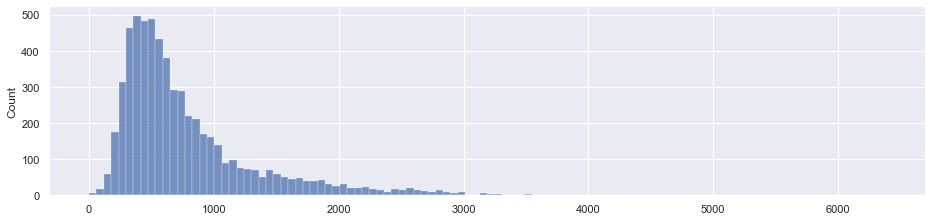

In [44]:
sns.displot(lyrics_lengths)
# sns.set(rc = {'figure.figsize':(25,8)})
plt.gcf().set_size_inches(15, 3)


In [ ]:
line1, = plt.plot(max_depths, max_depth_train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, max_depth_test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [12]:
X = lemmed_lyrics
y = combined_genre_data.Genres
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

In [23]:
pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

pipe_KNN = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', KNeighborsClassifier())
                    ])

# List of pipelines, List of pipeline names
pipelines = [pipe_NB, pipe_RF, pipe_KNN]
pipeline_names = ['Multinomail NB', 'Random Forest', "KNN"]

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)
    
# Compare accuracies
lemmed_basic_scores = []
for index, val in enumerate(pipelines):
    tup = (pipeline_names[index], val.score(X_test, y_test))
    lemmed_basic_scores.append(tup)
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.561
Random Forest pipeline test accuracy: 0.576
KNN pipeline test accuracy: 0.370


# Random Forest Classifier

In [26]:
GS_pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

rf_param_grid = dict(clf__n_estimators = [10, 30, 100],
                  clf__criterion = ['gini', 'entropy'],
                  clf__max_depth = [2, 6, 10], 
                  clf__min_samples_split = [5, 10],
                  clf__min_samples_leaf = [3, 6])


gs_RF = GridSearchCV(estimator=GS_pipe_RF,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3)

gs_RF.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                       ('tfidf_vectorizer', TfidfTransformer()),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [2, 6, 10],
                         'clf__min_samples_leaf': [3, 6],
                         'clf__min_samples_split': [5, 10],
                         'clf__n_estimators': [10, 30, 100]},
             scoring='accuracy')

In [27]:
rf_gs_testing_score = gs_RF.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(rf_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_RF.best_params_))

Mean Testing Score: 51.73%
Best Parameter Combination Found During Grid Search: 
{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}


# Naive Bayes

In [28]:
GS_pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])


sorted(GS_pipe_NB.get_params().keys())

nb_param_grid = dict(clf__alpha = [.01, .05, .1, .2, .4, 1])

gs_NB = GridSearchCV(estimator=GS_pipe_NB,
            param_grid=nb_param_grid,
            scoring='accuracy',
            cv=3)

gs_NB.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                       ('tfidf_vectorizer', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.01, 0.05, 0.1, 0.2, 0.4, 1]},
             scoring='accuracy')

In [29]:
nb_gs_testing_score = gs_NB.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(nb_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_NB.best_params_))

Mean Testing Score: 61.27%
Best Parameter Combination Found During Grid Search: 
{'clf__alpha': 0.05}


# KNN Classifier

In [30]:
GS_pipe_KNN = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', KNeighborsClassifier())
                    ])

knn_param_grid = dict(clf__n_neighbors = [100, 150, 200],
                     clf__p = [1, 2])

gs_KNN = GridSearchCV(estimator=GS_pipe_KNN,
            param_grid=knn_param_grid,
            scoring='accuracy',
            cv=3)

gs_KNN.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                       ('tfidf_vectorizer', TfidfTransformer()),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': [100, 150, 200], 'clf__p': [1, 2]},
             scoring='accuracy')

In [31]:
knn_gs_testing_score = gs_KNN.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(knn_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_KNN.best_params_))

Mean Testing Score: 49.2%
Best Parameter Combination Found During Grid Search: 
{'clf__n_neighbors': 200, 'clf__p': 2}
